In [1]:
import numpy as np
import random
import heapq
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, mutual_info_score
from skimage.metrics import structural_similarity as SSIM

In [2]:
# Load the dataset
image = np.load("images.npy")  # Hyperspectral data (1217 × 303 × 274)
labels = np.load("labels.npy")  # Ground truth (1217 × 303)
print(image.shape)
print(labels.shape)
print(np.unique(labels))
num_bands = image.shape[-1]  

(1217, 303, 274)
(1217, 303)
[ 0  1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16]


In [4]:
selected_region = image[0:128, 0:128, :]
nmi_matrix = np.zeros((num_bands, num_bands))
ssim_matrix = np.zeros((num_bands, num_bands))
dissimilarity_matrix = np.zeros((num_bands, num_bands))

In [5]:
def calculate_entropy(data):
    _, counts = np.unique(data, return_counts=True)
    probabilities = counts / counts.sum()
    if len(probabilities) == 1:
        return 0
    return -np.sum(probabilities * np.log2(probabilities))
def discretize_band(band, num_bins=256):
    band_min = np.min(band)
    band_max = np.max(band)
    bins = np.linspace(band_min, band_max, num_bins)
    discrete_band = np.digitize(band, bins) - 1 
    return discrete_band
for i in range(num_bands):
    for j in range(i + 1, num_bands):
        band_i = discretize_band(selected_region[:, :, i].flatten())
        band_j = discretize_band(selected_region[:, :, j].flatten())
        if len(np.unique(band_i)) > 1 and len(np.unique(band_j)) > 1:
            mi = mutual_info_score(band_i, band_j)
            h_i = calculate_entropy(band_i)
            h_j = calculate_entropy(band_j)
            if h_i > 0 and h_j > 0:
                dissimilarity_matrix[i, j] = h_i + h_j - 2 * mi
                dissimilarity_matrix[j, i] = dissimilarity_matrix[i, j]
                nmi_matrix[i, j] = 2 * mi / (h_i + h_j)
                nmi_matrix[j, i] = nmi_matrix[i, j]
            ssim_value = SSIM(
                selected_region[:, :, i],
                selected_region[:, :, j],
                data_range=selected_region[:, :, i].max() - selected_region[:, :, i].min()
            )
            ssim_matrix[i, j] = ssim_value
            ssim_matrix[j, i] = ssim_value
hybrid_similarity_matrix = nmi_matrix + ssim_matrix
def rank_bands(sim_matrix, dis_matrix, num_bands_to_select=50):
    avg_similarity = np.nanmean(sim_matrix, axis=1)
    dissimilarity = np.nanmin(dis_matrix, axis=1)
    range_similarity = avg_similarity.max() - avg_similarity.min()
    range_dissimilarity = dissimilarity.max() - dissimilarity.min()
    normalized_similarity = (avg_similarity - avg_similarity.min()) / range_similarity if range_similarity != 0 else np.zeros_like(avg_similarity)
    normalized_dissimilarity = (dissimilarity - dissimilarity.min()) / range_dissimilarity if range_dissimilarity != 0 else np.zeros_like(dissimilarity)
    scores = normalized_similarity * normalized_dissimilarity
    ranked_indices = np.argsort(scores)[::-1]
    return ranked_indices[:num_bands_to_select]
num_bands_to_select = 150
sr_nmi_vi_ranked_bands = rank_bands(nmi_matrix, dissimilarity_matrix, num_bands_to_select)

print(f"Top {num_bands_to_select} SR-NMI-VI Ranked Bands: {sr_nmi_vi_ranked_bands}")


Top 150 SR-NMI-VI Ranked Bands: [273  93  87  88  89  90  91  92  94  68  95  96  97  98  99 100  86  85
  84  83  82  81  80  79  78  77  76  75  74  73  72  71  70 101 102 103
 120 134 133 132 131 130 129 128 127 126 125 124 123 122 121 119 104 118
 117 116 115 114 113 112 111 110 109 108 107 106 105  69  67 272  24  18
  19  20  21  22  23  25  66  26  27  28  29  30  31  17  16  15  14  13
  12  11  10   9   8   7   6   5   4   3   2   1  32  33  34  51  65  64
  63  62  61  60  59  58  57  56  55  54  53  52  50  35  49  48  47  46
  45  44  43  42  41  40  39  38  37  36 135 136 137 230 224 225 226 227
 228 229 231 138 232 233]


In [6]:
labels_flat=labels.flatten()
sample_size=10000
import numpy as np
import random
import heapq
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score
POP_SIZE = 20   
N_GEN = 50     
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.7
N_BANDS = 50   
try:
    del creator.FitnessMax
    del creator.Individual
except AttributeError:
    pass

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)
sr_nmi_vi_ranked_bands = sr_nmi_vi_ranked_bands.tolist() if isinstance(sr_nmi_vi_ranked_bands, np.ndarray) else sr_nmi_vi_ranked_bands

def init_individual():
    return creator.Individual(random.sample(sr_nmi_vi_ranked_bands, N_BANDS))

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def mutate_individual(individual):
    if random.random() < MUTATION_RATE:
        idx_to_replace = random.randint(0, len(individual) - 1)
        available_bands = list(set(sr_nmi_vi_ranked_bands) - set(individual))
        if available_bands:
            individual[idx_to_replace] = random.choice(available_bands)
    return (individual,)
def crossover(parent1, parent2):
    crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child1_genes = list(set(parent1[:crossover_point] + parent2[crossover_point:]))[:N_BANDS]
    child2_genes = list(set(parent2[:crossover_point] + parent1[crossover_point:]))[:N_BANDS]
    while len(child1_genes) < N_BANDS:
        new_band = random.choice(sr_nmi_vi_ranked_bands)
        if new_band not in child1_genes:
            child1_genes.append(new_band)
    while len(child2_genes) < N_BANDS:
        new_band = random.choice(sr_nmi_vi_ranked_bands)
        if new_band not in child2_genes:
            child2_genes.append(new_band)
    return creator.Individual(child1_genes), creator.Individual(child2_genes)
def evaluate(individual):
    selected_indices = list(individual)
    X = image.reshape(-1, num_bands)[:, selected_indices]
    y = labels.ravel()
    random_indices = np.random.choice(len(labels_flat), size=sample_size, replace=False)
    X = X[random_indices, :]
    y = y[random_indices]
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        return (0,)  
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    if len(np.unique(y_train)) < 2:
        return (0,)
    clf = SVC()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    return (acc + kappa + f1,)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)
def run_ga():
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)  
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE, 
                        ngen=N_GEN, stats=stats, halloffame=hof, verbose=True)

    return hof[0]  
best_individual = run_ga()
print(f"Optimized Bands (GA-Wrapped SR-NMI-VI): {best_individual}")


gen	nevals	max    
0  	20    	1.79403
1  	15    	1.79403
2  	12    	1.79403
3  	14    	1.79403
4  	17    	1.79403
5  	18    	1.79403
6  	9     	1.79403
7  	17    	1.78655
8  	11    	1.76528
9  	15    	1.78032
10 	18    	1.81793
11 	18    	1.81793
12 	13    	1.81793
13 	16    	1.81793
14 	13    	1.81793
15 	14    	1.81793
16 	16    	1.81793
17 	10    	1.78794
18 	16    	1.78794
19 	13    	1.81541
20 	17    	1.79456
21 	16    	1.79456
22 	17    	1.78923
23 	17    	1.78241
24 	16    	1.79153
25 	14    	1.81852
26 	19    	1.7812 
27 	12    	1.83002
28 	15    	1.83002
29 	12    	1.83002
30 	16    	1.83002
31 	12    	1.83002
32 	15    	1.83002
33 	14    	1.78563
34 	17    	1.80643
35 	15    	1.81409
36 	16    	1.81409
37 	17    	1.81234
38 	17    	1.81385
39 	16    	1.81385
40 	17    	1.80917
41 	16    	1.80917
42 	18    	1.78337
43 	17    	1.80226
44 	16    	1.80226
45 	14    	1.80226
46 	16    	1.80226
47 	16    	1.80544
48 	15    	1.80544
49 	16    	1.80544
50 	17    	1.81908
Optimized Ba

In [7]:

X = image.reshape(-1, num_bands)[:, best_individual]
y = labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"{name} - Accuracy: {acc:.4f}, Kappa: {kappa:.4f}, F1-score: {f1:.4f}")


Decision Tree - Accuracy: 0.6801, Kappa: 0.6184, F1-score: 0.6808
Naïve Bayes - Accuracy: 0.3105, Kappa: 0.2619, F1-score: 0.3023
SVM - Accuracy: 0.7094, Kappa: 0.6410, F1-score: 0.6835
Random Forest - Accuracy: 0.7794, Kappa: 0.7314, F1-score: 0.7713


In [8]:
image = np.load('images.npy')
labels = np.load('labels.npy')
num_bands = image.shape[-1] 
selected_sr_nmi_vi=[273,  93,  87,  88,  89,  90,  91,  92,  94,  68,  95,  96,  97,  98,  99, 100,  86,  85,
  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70, 101, 102, 103,
 120, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122]

In [9]:

X = image.reshape(-1, num_bands)[:, selected_sr_nmi_vi]
y = labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"{name} - Accuracy: {acc:.4f}, Kappa: {kappa:.4f}, F1-score: {f1:.4f}")


Decision Tree - Accuracy: 0.6311, Kappa: 0.5598, F1-score: 0.6322
Naïve Bayes - Accuracy: 0.2500, Kappa: 0.1923, F1-score: 0.2285
SVM - Accuracy: 0.6408, Kappa: 0.5457, F1-score: 0.6009
Random Forest - Accuracy: 0.7346, Kappa: 0.6743, F1-score: 0.7238


In [3]:
selected_sr_nmi_vi=[273,  93,  87,  88,  89,  90,  91,  92,  94,  68]
print(len(selected_sr_nmi_vi))

X = image.reshape(-1, num_bands)[:, selected_sr_nmi_vi]
y = labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"{name} - Accuracy: {acc:.4f}, Kappa: {kappa:.4f}, F1-score: {f1:.4f}")


10
Decision Tree - Accuracy: 0.5689, Kappa: 0.4862, F1-score: 0.5701
Naïve Bayes - Accuracy: 0.2990, Kappa: 0.2330, F1-score: 0.2753
SVM - Accuracy: 0.5668, Kappa: 0.4521, F1-score: 0.5200
Random Forest - Accuracy: 0.6765, Kappa: 0.6024, F1-score: 0.6630


In [5]:
selected_sr_nmi_vi=[273,  93,  87,  88,  89,  90,  91,  92,  94,  68,  95,  96,  97,  98,  99, 100,  86,  85,
  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70, 101, 102, 103,
 120, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122]
selected_sr_nmi_vi=selected_sr_nmi_vi[0:30]
print(len(selected_sr_nmi_vi))

X = image.reshape(-1, num_bands)[:, selected_sr_nmi_vi]
y = labels.ravel()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
classifiers = {
    "Decision Tree": DecisionTreeClassifier(),
    "Naïve Bayes": GaussianNB(),
    "SVM": SVC(),
    "Random Forest": RandomForestClassifier(),
}

for name, clf in classifiers.items():
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")
    print(f"{name} - Accuracy: {acc:.4f}, Kappa: {kappa:.4f}, F1-score: {f1:.4f}")


30
Decision Tree - Accuracy: 0.5854, Kappa: 0.5057, F1-score: 0.5867
Naïve Bayes - Accuracy: 0.2502, Kappa: 0.1922, F1-score: 0.2290
SVM - Accuracy: 0.5987, Kappa: 0.4910, F1-score: 0.5523
Random Forest - Accuracy: 0.6978, Kappa: 0.6277, F1-score: 0.6844


In [3]:
selected_sr_nmi_vi=[273,  93,  87,  88,  89,  90,  91,  92,  94,  68,  95,  96,  97,  98,  99, 100,  86,  85,
  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70, 101, 102, 103,
 120, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122]

num_bands = image.shape[-1]
y = labels.ravel()
accuracies = []

for num_selected in range(1, len(selected_sr_nmi_vi) + 1):
    X = image.reshape(-1, num_bands)[:, selected_sr_nmi_vi[:num_selected]]
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    
    print(f"Bands: {num_selected}, Decision Tree - Accuracy: {acc:.4f}")

print("Final Accuracies:", accuracies)


Bands: 1, Decision Tree - Accuracy: 0.4255
Bands: 2, Decision Tree - Accuracy: 0.5155
Bands: 3, Decision Tree - Accuracy: 0.5176
Bands: 4, Decision Tree - Accuracy: 0.5184
Bands: 5, Decision Tree - Accuracy: 0.5166
Bands: 6, Decision Tree - Accuracy: 0.5207
Bands: 7, Decision Tree - Accuracy: 0.5213
Bands: 8, Decision Tree - Accuracy: 0.5239
Bands: 9, Decision Tree - Accuracy: 0.5251
Bands: 10, Decision Tree - Accuracy: 0.5673
Bands: 11, Decision Tree - Accuracy: 0.5657
Bands: 12, Decision Tree - Accuracy: 0.5703
Bands: 13, Decision Tree - Accuracy: 0.5721
Bands: 14, Decision Tree - Accuracy: 0.5726
Bands: 15, Decision Tree - Accuracy: 0.5795
Bands: 16, Decision Tree - Accuracy: 0.5805
Bands: 17, Decision Tree - Accuracy: 0.5803
Bands: 18, Decision Tree - Accuracy: 0.5791
Bands: 19, Decision Tree - Accuracy: 0.5792
Bands: 20, Decision Tree - Accuracy: 0.5795
Bands: 21, Decision Tree - Accuracy: 0.5804
Bands: 22, Decision Tree - Accuracy: 0.5787
Bands: 23, Decision Tree - Accuracy: 0.58

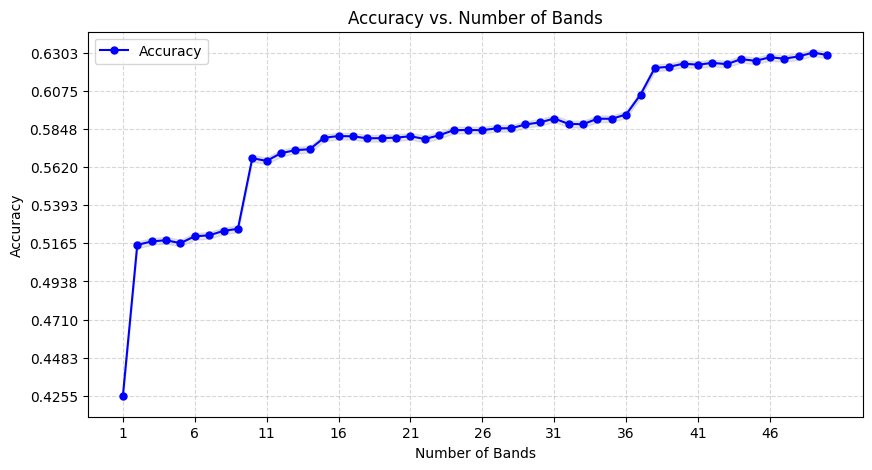

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Data
bands = np.arange(1, 51)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(bands, accuracies, marker='o', linestyle='-', color='b', markersize=5, label='Accuracy')

# Highlight minor variations
plt.fill_between(bands, np.array(accuracies) - 0.002, np.array(accuracies) + 0.002, color='gray', alpha=0.2)

# Labels and Title
plt.xlabel("Number of Bands")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Bands")
plt.xticks(np.arange(1, 51, 5))
plt.yticks(np.linspace(min(accuracies), max(accuracies), 10))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Show plot
plt.show()


In [1]:
import numpy as np
import random
from deap import base, creator, tools, algorithms
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, cohen_kappa_score, f1_score, mutual_info_score
from sklearn.tree import DecisionTreeClassifier
image = np.load('images.npy')
labels = np.load('labels.npy')
num_bands = image.shape[-1]  
print(image.shape)
print(labels.shape)

(1217, 303, 274)
(1217, 303)


In [5]:
sr_nmi_vi_ranked_bands=[273,  93,  87,  88,  89,  90,  91,  92,  94,  68,  95,  96,  97,  98,  99, 100,  86,  85,
  84,  83,  82,  81,  80,  79,  78,  77,  76,  75,  74,  73,  72,  71,  70, 101, 102, 103,
 120, 134, 133, 132, 131, 130, 129, 128, 127, 126, 125, 124, 123, 122]

In [6]:
POP_SIZE = 10   
N_GEN = 30     
MUTATION_RATE = 0.2
CROSSOVER_RATE = 0.7

# Initialize DEAP
try:
    del creator.FitnessMax
    del creator.Individual
except AttributeError:
    pass

creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", list, fitness=creator.FitnessMax)


2
gen	nevals	max    
0  	10    	2.55686
1  	7     	2.56415
2  	6     	2.56415
3  	10    	2.5865 
4  	7     	2.5865 
5  	5     	2.5865 
6  	9     	2.58957
7  	8     	2.61274
8  	9     	2.60227
9  	7     	2.60227
10 	4     	2.60227
11 	7     	2.60227
12 	8     	2.57904
13 	10    	2.58979
14 	4     	2.58979
15 	10    	2.63123
16 	10    	2.59397
17 	8     	2.59487
18 	7     	2.59487
19 	9     	2.59487
20 	8     	2.59432
21 	8     	2.59432
22 	6     	2.58024
23 	8     	2.58222
24 	8     	2.60217
25 	4     	2.60217
26 	10    	2.5915 
27 	10    	2.57279
28 	10    	2.6065 
29 	8     	2.59302
30 	5     	2.59302
Optimized Bands (GA-Wrapped SR-NMI-VI): [128, 79]
Bands: 2, Accuracy: 0.4851
3
gen	nevals	max    
0  	10    	2.56614
1  	7     	2.60437
2  	5     	2.62393
3  	6     	2.62241
4  	4     	2.66693
5  	6     	2.66693
6  	8     	2.66693
7  	6     	2.66693
8  	8     	2.66693
9  	4     	2.66693
10 	4     	2.66693
11 	8     	2.66693
12 	7     	2.66516
13 	10    	2.63178
14 	6     	2.63178
15 	4  

20 	10    	2.67696
21 	9     	2.68267
22 	4     	2.68651
23 	8     	2.68267
24 	10    	2.68691
25 	6     	2.67015
26 	7     	2.69007
27 	8     	2.67252
28 	5     	2.67252
29 	5     	2.70735
30 	9     	2.69214
Optimized Bands (GA-Wrapped SR-NMI-VI): [97, 98, 130, 68, 132, 70, 100, 103, 73, 74, 76, 123, 95]
Bands: 13, Accuracy: 0.5781
14
gen	nevals	max    
0  	10    	2.67132
1  	8     	2.6707 
2  	8     	2.68755
3  	7     	2.68755
4  	9     	2.68973
5  	7     	2.68735
6  	7     	2.68735
7  	7     	2.68735
8  	8     	2.66326
9  	7     	2.67058
10 	8     	2.67003
11 	10    	2.66867
12 	10    	2.68101
13 	10    	2.64646
14 	8     	2.69831
15 	9     	2.69831
16 	4     	2.69831
17 	7     	2.68097
18 	4     	2.68097
19 	10    	2.67403
20 	6     	2.67403
21 	4     	2.67403
22 	6     	2.68248
23 	7     	2.68248
24 	9     	2.68192
25 	8     	2.70201
26 	8     	2.67847
27 	7     	2.69433
28 	8     	2.69433
29 	8     	2.69433
30 	5     	2.69433
Optimized Bands (GA-Wrapped SR-NMI-VI): [130, 131, 133

12 	10    	2.68509
13 	10    	2.6955 
14 	7     	2.70972
15 	5     	2.70972
16 	9     	2.6955 
17 	7     	2.69722
18 	9     	2.69375
19 	10    	2.67427
20 	8     	2.67427
21 	9     	2.68845
22 	6     	2.68845
23 	8     	2.68845
24 	8     	2.69622
25 	10    	2.68611
26 	10    	2.70388
27 	8     	2.70694
28 	7     	2.69244
29 	8     	2.70268
30 	8     	2.70268
Optimized Bands (GA-Wrapped SR-NMI-VI): [129, 134, 273, 68, 70, 73, 74, 75, 76, 77, 79, 86, 87, 88, 89, 126, 91, 95, 97, 100, 103, 120, 122, 124]
Bands: 24, Accuracy: 0.6292
25
gen	nevals	max    
0  	10    	2.68231
1  	6     	2.6711 
2  	8     	2.67364
3  	10    	2.69065
4  	10    	2.68392
5  	7     	2.68894
6  	8     	2.69778
7  	9     	2.69935
8  	8     	2.71766
9  	7     	2.68236
10 	9     	2.69355
11 	5     	2.68335
12 	8     	2.68877
13 	8     	2.68335
14 	6     	2.68335
15 	8     	2.70334
16 	8     	2.70334
17 	7     	2.69433
18 	4     	2.69433
19 	9     	2.69433
20 	7     	2.69433
21 	8     	2.69438
22 	10    	2.68716
23 	7 

20 	5     	2.68443
21 	6     	2.68443
22 	3     	2.68443
23 	8     	2.68443
24 	8     	2.70175
25 	7     	2.70175
26 	8     	2.70175
27 	10    	2.65903
28 	8     	2.67282
29 	6     	2.68919
30 	8     	2.68919
Optimized Bands (GA-Wrapped SR-NMI-VI): [128, 131, 102, 124, 71, 126, 87, 97, 98, 68, 73, 70, 78, 123, 95, 86, 125, 92, 94, 93, 99, 273, 83, 77, 88, 100, 130, 129, 132, 120, 91, 76, 101, 79]
Bands: 34, Accuracy: 0.6192
35
gen	nevals	max    
0  	10    	2.67577
1  	5     	2.68238
2  	8     	2.68238
3  	5     	2.68238
4  	9     	2.6787 
5  	6     	2.6787 
6  	4     	2.6787 
7  	6     	2.6787 
8  	6     	2.6787 
9  	6     	2.6787 
10 	10    	2.66328
11 	7     	2.66328
12 	7     	2.66328
13 	6     	2.66328
14 	9     	2.67965
15 	10    	2.68528
16 	10    	2.66486
17 	8     	2.68601
18 	6     	2.68283
19 	8     	2.68283
20 	8     	2.68283
21 	9     	2.64315
22 	9     	2.64675
23 	4     	2.65762
24 	7     	2.66943
25 	8     	2.69759
26 	9     	2.66034
27 	6     	2.68926
28 	4     	2.68926

5  	8     	2.70458
6  	8     	2.69323
7  	6     	2.69198
8  	10    	2.685  
9  	6     	2.685  
10 	9     	2.69785
11 	7     	2.6769 
12 	6     	2.69015
13 	10    	2.71517
14 	7     	2.71078
15 	10    	2.68797
16 	7     	2.68797
17 	9     	2.67946
18 	9     	2.69234
19 	8     	2.71307
20 	9     	2.71307
21 	10    	2.69376
22 	4     	2.69376
23 	5     	2.69376
24 	5     	2.71048
25 	8     	2.71048
26 	10    	2.70904
27 	8     	2.69893
28 	8     	2.69893
29 	4     	2.69893
30 	10    	2.67832
Optimized Bands (GA-Wrapped SR-NMI-VI): [128, 129, 130, 131, 132, 133, 134, 273, 68, 70, 71, 72, 73, 74, 75, 76, 77, 79, 80, 81, 82, 83, 84, 86, 89, 90, 91, 94, 95, 97, 98, 99, 100, 101, 102, 103, 120, 122, 123, 124, 125, 126, 127, 93]
Bands: 44, Accuracy: 0.6320
45
gen	nevals	max    
0  	10    	2.71111
1  	9     	2.70405
2  	7     	2.68921
3  	6     	2.68905
4  	8     	2.701  
5  	6     	2.71138
6  	10    	2.70272
7  	4     	2.70272
8  	10    	2.69785
9  	10    	2.68269
10 	5     	2.69193
11 	8     	

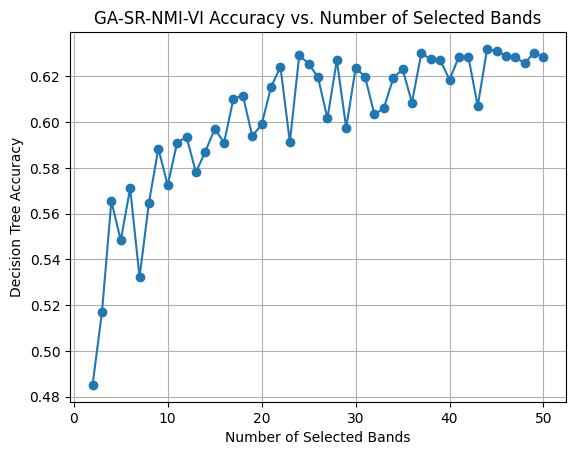

In [7]:
sr_nmi_vi_ranked_bands = sr_nmi_vi_ranked_bands.tolist() if isinstance(sr_nmi_vi_ranked_bands, np.ndarray) else sr_nmi_vi_ranked_bands

def init_individual():
    return creator.Individual(random.sample(sr_nmi_vi_ranked_bands, N_BANDS))

toolbox = base.Toolbox()
toolbox.register("individual", init_individual)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)

def mutate_individual(individual):
    if random.random() < MUTATION_RATE:
        idx_to_replace = random.randint(0, len(individual) - 1)
        available_bands = list(set(sr_nmi_vi_ranked_bands) - set(individual))
        if available_bands:
            individual[idx_to_replace] = random.choice(available_bands)
    return (individual,)
def crossover(parent1, parent2):
    crossover_point = random.randint(1, min(len(parent1), len(parent2)) - 1)
    child1_genes = list(set(parent1[:crossover_point] + parent2[crossover_point:]))[:N_BANDS]
    child2_genes = list(set(parent2[:crossover_point] + parent1[crossover_point:]))[:N_BANDS]
    while len(child1_genes) < N_BANDS:
        new_band = random.choice(sr_nmi_vi_ranked_bands)
        if new_band not in child1_genes:
            child1_genes.append(new_band)
    while len(child2_genes) < N_BANDS:
        new_band = random.choice(sr_nmi_vi_ranked_bands)
        if new_band not in child2_genes:
            child2_genes.append(new_band)
    return creator.Individual(child1_genes), creator.Individual(child2_genes)
def evaluate(individual):
    selected_indices = list(individual)
    X = image.reshape(-1, num_bands)[:, selected_indices]
    y = labels.ravel()
    X = X[0:5000, :]
    y = y[0:5000]
    unique_classes = np.unique(y)
    if len(unique_classes) < 2:
        return (0,)  
    try:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    except ValueError:
        X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3)

    if len(np.unique(y_train)) < 2:
        return (0,)
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    kappa = cohen_kappa_score(y_test, y_pred)
    f1 = f1_score(y_test, y_pred, average="weighted")

    return (acc + kappa + f1,)
toolbox.register("mate", crossover)
toolbox.register("mutate", mutate_individual)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("evaluate", evaluate)
def run_ga():
    pop = toolbox.population(n=POP_SIZE)
    hof = tools.HallOfFame(1)  
    stats = tools.Statistics(lambda ind: ind.fitness.values)
    stats.register("max", np.max)
    
    algorithms.eaSimple(pop, toolbox, cxpb=CROSSOVER_RATE, mutpb=MUTATION_RATE, 
                        ngen=N_GEN, stats=stats, halloffame=hof, verbose=True)

    return hof[0]  

accuracies = []
num_band_range = np.arange(2, 51)
for N_BANDS in num_band_range:
    print(N_BANDS)
    best_individual = run_ga()
    print(f"Optimized Bands (GA-Wrapped SR-NMI-VI): {best_individual}")
    selected_bands = list(best_individual)
    X = image.reshape(-1, num_bands)[:, selected_bands]
    y = labels.ravel()
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, stratify=y)
    clf = DecisionTreeClassifier()
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    acc = accuracy_score(y_test, y_pred)
    accuracies.append(acc)
    print(f"Bands: {N_BANDS}, Accuracy: {acc:.4f}")

plt.plot(num_band_range, accuracies, marker='o')
plt.xlabel("Number of Selected Bands")
plt.ylabel("Decision Tree Accuracy")
plt.title("GA-SR-NMI-VI Accuracy vs. Number of Selected Bands")
plt.grid(True)
plt.show()

In [8]:
print (accuracies)

[0.48508488058865007, 0.5169218809321497, 0.5654186176848119, 0.5483249868927739, 0.5710682841285051, 0.532207618462206, 0.5647677761104984, 0.5884240594435305, 0.5724151646086815, 0.591054544139714, 0.5935946341727985, 0.5780738705186845, 0.5870681394970441, 0.5970477103031837, 0.5910907020049536, 0.6103357257787501, 0.6116464483936869, 0.5939110154936452, 0.599009274492434, 0.6153707085133694, 0.6241661092329109, 0.5912624518648419, 0.6291649341022906, 0.6256033843761865, 0.6196011787464069, 0.6016216802559977, 0.6270768173847016, 0.597508723084989, 0.6236327807206262, 0.6199537179324933, 0.6033843761864299, 0.6060239003489234, 0.6191582448972213, 0.6231988863377507, 0.6085639903820078, 0.6302677489920995, 0.6274474355034079, 0.627140093648871, 0.618579719053387, 0.6286044871910762, 0.6286948818541753, 0.607054399508253, 0.6320304449225318, 0.6309637878979625, 0.6291016578381212, 0.6284688951964276, 0.6257299369045252, 0.6303943015204382, 0.6284508162638078]


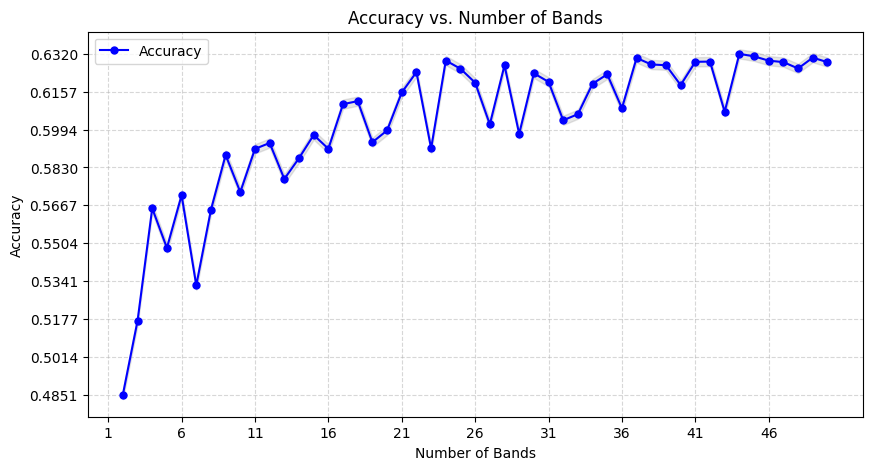

In [9]:
import matplotlib.pyplot as plt
import numpy as np

# Data
bands = np.arange(2, 51)

# Plot
plt.figure(figsize=(10, 5))
plt.plot(bands, accuracies, marker='o', linestyle='-', color='b', markersize=5, label='Accuracy')

# Highlight minor variations
plt.fill_between(bands, np.array(accuracies) - 0.002, np.array(accuracies) + 0.002, color='gray', alpha=0.2)

# Labels and Title
plt.xlabel("Number of Bands")
plt.ylabel("Accuracy")
plt.title("Accuracy vs. Number of Bands")
plt.xticks(np.arange(1, 51, 5))
plt.yticks(np.linspace(min(accuracies), max(accuracies), 10))
plt.grid(True, linestyle="--", alpha=0.5)
plt.legend()

# Show plot
plt.show()


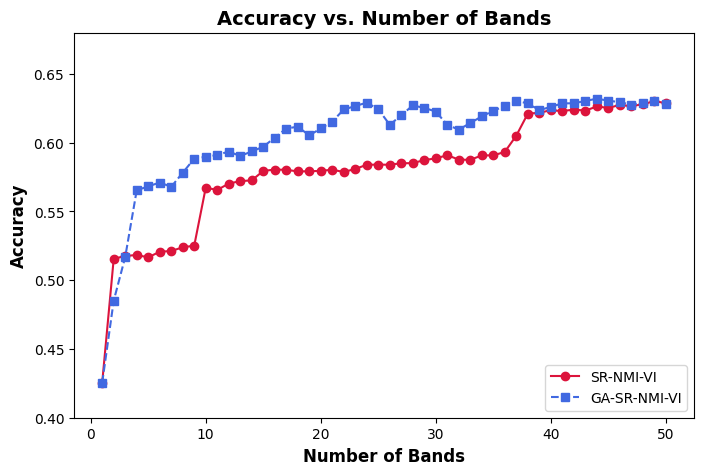

In [1]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (Replace these with your actual accuracy values)
num_bands = np.arange(1, 51)
accuracy1 = [0.42553287653896915, 0.5155478820530436, 0.5176450382369425, 0.5183501166091155, 0.5166235785439227, 0.5207184567823115, 0.5212608247609061, 0.5239365067886392, 0.525147795274167, 0.5672717082783433, 0.5656626832751794, 0.570281850559543, 0.5720716648889049, 0.5726230723338094, 0.5794840272630304, 0.5804783685571204, 0.580315658163542, 0.5791314880769439, 0.5792399616726629, 0.5795382640608898, 0.5803698949614015, 0.5786975936940683, 0.5809574602715456, 0.5839495236201254, 0.5841122340137038, 0.5839676025527453, 0.5850975358414839, 0.5851246542404136, 0.5874025997505107, 0.5885958093034187, 0.5909370310776851, 0.5877189810713576, 0.5875472312114692, 0.5908014390830365, 0.5907833601504168, 0.5933234501835012, 0.605165151049482, 0.6211469274854012, 0.6217796901270949, 0.623659899119556, 0.6230180970115524, 0.6241209119013613, 0.623361596731329, 0.626344620613599, 0.6253412398531991, 0.6274474355034079, 0.626642923001826, 0.6279626850830727, 0.6302587095257896, 0.6287943159835844]# Example data
accuracy3 = [0.42553287653896915, 0.48508488058865007, 0.5169218809321497, 0.5654186176848119, 0.5483249868927739, 0.5710682841285051, 0.532207618462206, 0.5647677761104984, 0.5884240594435305, 0.5724151646086815, 0.591054544139714, 0.5935946341727985, 0.5780738705186845, 0.5870681394970441, 0.5970477103031837, 0.5910907020049536, 0.6103357257787501, 0.6116464483936869, 0.5939110154936452, 0.599009274492434, 0.6153707085133694, 0.6241661092329109, 0.5912624518648419, 0.6291649341022906, 0.6256033843761865, 0.6196011787464069, 0.6016216802559977, 0.6270768173847016, 0.597508723084989, 0.6236327807206262, 0.6199537179324933, 0.6033843761864299, 0.6060239003489234, 0.6191582448972213, 0.6231988863377507, 0.6085639903820078, 0.6302677489920995, 0.6274474355034079, 0.627140093648871, 0.618579719053387, 0.6286044871910762, 0.6286948818541753, 0.607054399508253, 0.6320304449225318, 0.6309637878979625, 0.6291016578381212, 0.6284688951964276, 0.6257299369045252, 0.6303943015204382, 0.6284508162638078]  # Example data
accuracy2=[0.42553287653896915, 0.48508488058865007, 0.5169218809321497, 0.5654186176848119,
 0.5682434509066585, 0.5710682841285051, 0.5679180301195017, 0.578171044781516,
 0.5884240594435305, 0.5897393017916223, 0.591054544139714, 0.5935946341727985,
 0.5903313868349213, 0.5936895485690525, 0.5970477103031837, 0.6036917180409669,
 0.6103357257787501, 0.6116464483936869, 0.6053278614430604, 0.6103492849782148,
 0.6153707085133694, 0.6241661092329109, 0.6266655216676007, 0.6291649341022906,
 0.6243830564243487, 0.6130023683401732, 0.6200395928624374, 0.6270768173847016,
 0.6253547990526639, 0.6226542584925786, 0.6130193173395042, 0.6095216088442138,
 0.6143399268707175, 0.6191582448972213, 0.6231988863377507, 0.626733317664925,
 0.6302677489920995, 0.6287039213204852, 0.6236418201869361, 0.6261231536890062,
 0.6286044871910762, 0.6286948818541753, 0.6303626633883536, 0.6320304449225318,
 0.6305660513803265, 0.629517473288377, 0.627623705096451, 0.6290090033084446,
 0.6303943015204382, 0.6284508162638078]


# Plot
plt.figure(figsize=(8, 5))
plt.plot(num_bands, accuracy1, marker='o', linestyle='-', color='crimson', label='SR-NMI-VI')
plt.plot(num_bands, accuracy2, marker='s', linestyle='--', color='royalblue', label='GA-SR-NMI-VI')

# Labels and title
plt.xlabel("Number of Bands", fontsize=12, fontweight='bold', color='black')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold', color='black')
plt.title("Accuracy vs. Number of Bands", fontsize=14, fontweight='bold', color='black')

# Set y-axis limits based on accuracy range
plt.ylim(0.4, 0.68)  # Adjusted to focus on your accuracy range

# Legend
plt.legend(loc='lower right', fontsize=10)

plt.style.use("default")

# Show plot
plt.show()


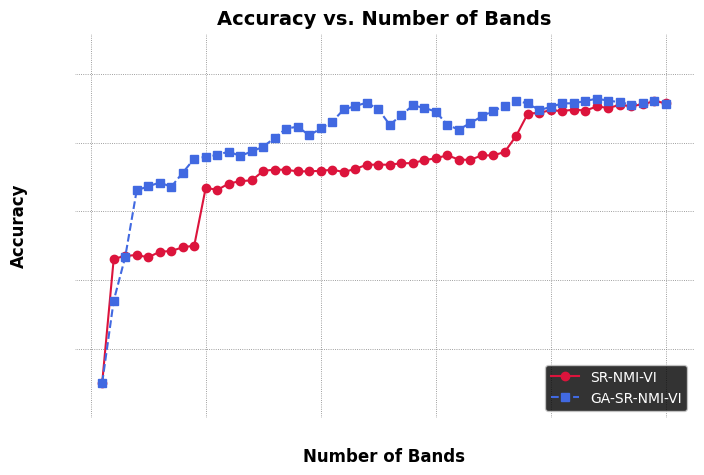

In [7]:
import numpy as np
import matplotlib.pyplot as plt

# Sample data (Replace these with your actual accuracy values)
num_bands = np.arange(1, 51)
accuracy1 = [0.42553287653896915, 0.5155478820530436, 0.5176450382369425, 0.5183501166091155, 0.5166235785439227, 0.5207184567823115, 0.5212608247609061, 0.5239365067886392, 0.525147795274167, 0.5672717082783433, 0.5656626832751794, 0.570281850559543, 0.5720716648889049, 0.5726230723338094, 0.5794840272630304, 0.5804783685571204, 0.580315658163542, 0.5791314880769439, 0.5792399616726629, 0.5795382640608898, 0.5803698949614015, 0.5786975936940683, 0.5809574602715456, 0.5839495236201254, 0.5841122340137038, 0.5839676025527453, 0.5850975358414839, 0.5851246542404136, 0.5874025997505107, 0.5885958093034187, 0.5909370310776851, 0.5877189810713576, 0.5875472312114692, 0.5908014390830365, 0.5907833601504168, 0.5933234501835012, 0.605165151049482, 0.6211469274854012, 0.6217796901270949, 0.623659899119556, 0.6230180970115524, 0.6241209119013613, 0.623361596731329, 0.626344620613599, 0.6253412398531991, 0.6274474355034079, 0.626642923001826, 0.6279626850830727, 0.6302587095257896, 0.6287943159835844]

accuracy2 = [0.42553287653896915, 0.48508488058865007, 0.5169218809321497, 0.5654186176848119,
 0.5682434509066585, 0.5710682841285051, 0.5679180301195017, 0.578171044781516,
 0.5884240594435305, 0.5897393017916223, 0.591054544139714, 0.5935946341727985,
 0.5903313868349213, 0.5936895485690525, 0.5970477103031837, 0.6036917180409669,
 0.6103357257787501, 0.6116464483936869, 0.6053278614430604, 0.6103492849782148,
 0.6153707085133694, 0.6241661092329109, 0.6266655216676007, 0.6291649341022906,
 0.6243830564243487, 0.6130023683401732, 0.6200395928624374, 0.6270768173847016,
 0.6253547990526639, 0.6226542584925786, 0.6130193173395042, 0.6095216088442138,
 0.6143399268707175, 0.6191582448972213, 0.6231988863377507, 0.626733317664925,
 0.6302677489920995, 0.6287039213204852, 0.6236418201869361, 0.6261231536890062,
 0.6286044871910762, 0.6286948818541753, 0.6303626633883536, 0.6320304449225318,
 0.6305660513803265, 0.629517473288377, 0.627623705096451, 0.6290090033084446,
 0.6303943015204382, 0.6284508162638078]

# Plot
plt.figure(figsize=(8, 5))
plt.plot(num_bands, accuracy1, marker='o', linestyle='-', color='crimson', label='SR-NMI-VI')
plt.plot(num_bands, accuracy2, marker='s', linestyle='--', color='royalblue', label='GA-SR-NMI-VI')

# Labels and title
plt.xlabel("Number of Bands", fontsize=12, fontweight='bold', color='black')
plt.ylabel("Accuracy", fontsize=12, fontweight='bold', color='black')
plt.title("Accuracy vs. Number of Bands", fontsize=14, fontweight='bold', color='black')

# Set y-axis limits based on accuracy range
plt.ylim(0.4, 0.68)  # Adjusted to focus on your accuracy range

# Legend
plt.legend(loc='lower right', fontsize=10)

# White background settings
plt.grid(color='gray', linestyle=':', linewidth=0.6)
plt.gca().set_facecolor('white')
plt.gcf().set_facecolor('white')

# Show plot
plt.show()
